In [0]:
# ─────────────────────────────────────────────
# Spark Core
# ─────────────────────────────────────────────
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, lit, to_timestamp, to_date, year, month, dayofmonth,
    count, countDistinct, sum, avg, min, max,
    round, when, datediff, current_date, concat_ws,
    monotonically_increasing_id
)
from pyspark.sql.functions import max as spark_max

# ─────────────────────────────────────────────
# Spark MLlib
# ─────────────────────────────────────────────
from pyspark.ml.feature import (
    VectorAssembler, PCA, StringIndexer, StandardScaler,
    MinMaxScaler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# ─────────────────────────────────────────────
# Python Built-ins and Data Science Libraries
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import (
    silhouette_samples, silhouette_score,
    confusion_matrix
)

# ─────────────────────────────────────────────
# Utilities
# ─────────────────────────────────────────────
from itertools import combinations


In [0]:
# Start Spark session
spark = SparkSession.builder.appName("Project_Group77").getOrCreate()

In [0]:
# File location and type
file_location = "/FileStore/df_clustering.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_clustering = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df_clustering.limit(10).display()
df_clustering.schema


Customer ID,num_invoices,num_products,total_quantity,total_price,avg_unit_price,first_purchase_date,last_purchase_date,purchase_span_days,avg_quantity_per_invoice,recency_days,2022-12,2023-1,2023-10,2023-11,2023-12,2023-2,2023-3,2023-4,2023-5,2023-6,2023-7,2023-8,2023-9,2024-1,2024-10,2024-11,2024-12,2024-2,2024-3,2024-4,2024-5,2024-6,2024-7,2024-8,2024-9
13285,6,182,2457,3364.59,2.33,2023-03-25,2024-11-16,602,409.5,23,0,0,0,0,0,0,21,23,0,0,0,0,0,0,0,50,0,52,0,30,0,0,55,0,0
14570,3,64,431,613.75,3.29,2023-09-22,2024-03-04,164,143.67,280,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,29,0,0,0,0,0,0
15846,1,27,79,107.01,1.82,2023-11-19,2023-11-19,0,79.0,386,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25462,1,158,278,1281.03,6.11,2024-05-24,2024-05-24,0,278.0,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158,0,0,0,0
17420,8,43,444,943.68,3.41,2023-11-03,2024-10-20,352,55.5,50,0,0,0,22,7,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,14,0,0,0
24171,1,13,22,43.25,2.49,2024-03-18,2024-03-18,0,22.0,266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0
16386,3,127,700,1068.16,2.05,2023-11-17,2024-11-11,360,233.33,28,0,0,0,58,0,0,0,0,0,0,0,0,0,0,0,77,0,0,4,0,0,0,0,0,0
18024,3,21,148,236.78,2.66,2024-07-10,2024-07-10,0,49.33,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0
15727,15,426,5908,9371.71,3.57,2023-01-24,2024-11-23,669,393.87,16,0,99,0,50,66,0,0,0,87,13,116,19,0,32,0,39,0,0,0,46,14,0,30,74,0
16339,1,17,21,94.05,4.96,2024-02-28,2024-02-28,0,21.0,285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0


Out[13]: StructType([StructField('Customer ID', IntegerType(), True), StructField('num_invoices', IntegerType(), True), StructField('num_products', IntegerType(), True), StructField('total_quantity', IntegerType(), True), StructField('total_price', DoubleType(), True), StructField('avg_unit_price', DoubleType(), True), StructField('first_purchase_date', DateType(), True), StructField('last_purchase_date', DateType(), True), StructField('purchase_span_days', IntegerType(), True), StructField('avg_quantity_per_invoice', DoubleType(), True), StructField('recency_days', IntegerType(), True), StructField('2022-12', IntegerType(), True), StructField('2023-1', IntegerType(), True), StructField('2023-10', IntegerType(), True), StructField('2023-11', IntegerType(), True), StructField('2023-12', IntegerType(), True), StructField('2023-2', IntegerType(), True), StructField('2023-3', IntegerType(), True), StructField('2023-4', IntegerType(), True), StructField('2023-5', IntegerType(), True), Struc

# Clustering

### Feature Selection

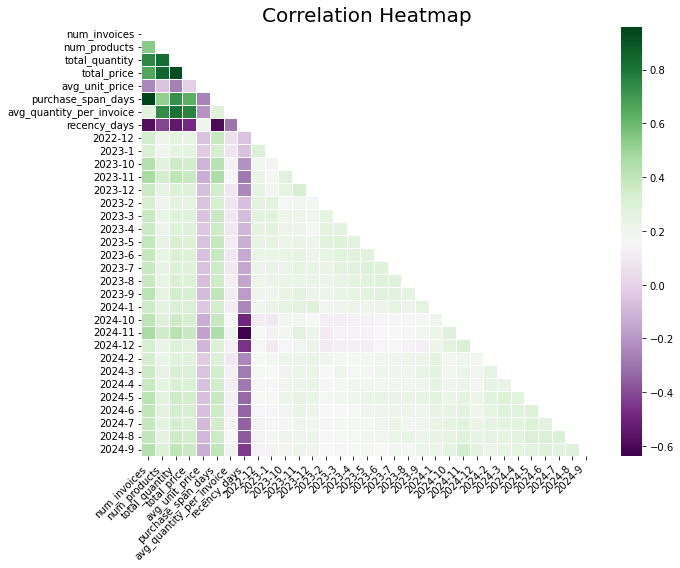

In [0]:
# Define your list of metric features
new_metric_features = ['num_invoices','num_products','total_quantity','total_price','avg_unit_price','purchase_span_days','avg_quantity_per_invoice','recency_days','2022-12','2023-1','2023-10','2023-11','2023-12','2023-2','2023-3','2023-4','2023-5','2023-6','2023-7','2023-8','2023-9','2024-1','2024-10','2024-11','2024-12','2024-2','2024-3','2024-4','2024-5','2024-6','2024-7','2024-8','2024-9']  # Replace with your actual column names

# Step 1: Assemble features into a single vector column required by Spark ML
assembler = VectorAssembler(inputCols=new_metric_features, outputCol="features_vector")
df_vector = assembler.transform(df_clustering).select("features_vector")

# Step 2: Compute Spearman correlation matrix
correlation_result = Correlation.corr(df_vector, "features_vector", method="spearman").head()
corr_matrix = correlation_result[0].toArray()

# Step 3: Convert Spark correlation matrix to Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=new_metric_features, columns=new_metric_features)

# Step 4: Create a mask for the upper triangle (for styling like your pandas version)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Step 5: Plot heatmap using Seaborn & Matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_df, mask=mask, annot=False, cmap='PRGn', cbar=True, square=False, linewidths=0.5)

# Customize plot
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot in Databricks
plt.show()


In [0]:
# Step 6: Extract pairs with strong correlations (|correlation| > 0.8)
strong_corr_pairs = []

for i, j in combinations(range(len(new_metric_features)), 2):
    corr_value = corr_df.iloc[i, j]
    if abs(corr_value) > 0.8:
        strong_corr_pairs.append((new_metric_features[i], new_metric_features[j], corr_value))

# Step 7: Create a Pandas DataFrame from the results
strong_corr_df = pd.DataFrame(strong_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Optional: Sort by absolute correlation descending
strong_corr_df["AbsCorrelation"] = strong_corr_df["Correlation"].abs()
strong_corr_df.sort_values(by="AbsCorrelation", ascending=False, inplace=True)
strong_corr_df.drop(columns="AbsCorrelation", inplace=True)

# Step 8: Display the result in Databricks
display(strong_corr_df)

Feature 1,Feature 2,Correlation
num_invoices,purchase_span_days,0.9573801878547392
total_quantity,total_price,0.9223927527958522
num_products,total_price,0.8523866314539023
num_products,total_quantity,0.8274046161703706
total_quantity,avg_quantity_per_invoice,0.811560111828839


In [0]:
vb_features = ["Customer ID", "num_products", "num_invoices", "total_price", "avg_unit_price", "recency_days", "avg_quantity_per_invoice"]

df_vb = df_clustering.select(*vb_features)
#df_vb.limit(10).display()

### Clustering using KMEANS

In [0]:
# Start Spark session
spark = SparkSession.builder.appName("CustomerClustering").getOrCreate()

# Assemble all features into a single vector
# Exclude 'clientID' from the list of features
feature_cols = [col for col in df_vb.columns if col != "Customer ID"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
assembled = assembler.transform(df_vb)

# Scale features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)

# Define number of clusters
kmeans = KMeans(featuresCol="features", k=3, seed=1)  # Use default 'prediction' column
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)


# Evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.7685266695191887


cost = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(scaled_data)
    cost.append(model.summary.trainingCost)

# Plot the elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost (Within Set Sum of Squared Errors)")
plt.title("Elbow Method for Optimal K (Value-Based)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
# Show number of customers per cluster
predictions.groupBy("prediction").count().orderBy("prediction").show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2109|
|         1| 4524|
|         2| 2810|
+----------+-----+



In [0]:
#display(predictions)

In [0]:
# Select only 'Customer ID' and 'prediction' from predictions
predictions_selected = predictions.select("Customer ID", "prediction")

# Perform the left join
df_final = df_clustering.join(predictions_selected, on="Customer ID", how="left")
#df_final.limit(10).display()

# Exporting CVS

In [0]:
df_pandas = df_final.toPandas()

In [0]:
df_pandas.to_csv("/tmp/df_final.csv", index=False)

In [0]:
dbutils.fs.cp("file:/tmp/df_final.csv", "dbfs:/FileStore/df_final.csv")

# Profiling

In [0]:
profiling_time = ['2022-12','2023-1','2023-10','2023-11','2023-12','2023-2','2023-3','2023-4','2023-5','2023-6','2023-7','2023-8','2023-9','2024-1','2024-10','2024-11','2024-12','2024-2','2024-3','2024-4','2024-5','2024-6','2024-7','2024-8','2024-9']

In [0]:
# Group by 'prediction' and sum selected columns
agg_exprs = [F.sum(col).alias(col) for col in profiling_time]

df_time_cluster = df_final.groupBy('prediction').agg(*agg_exprs)
#display(df_time_cluster)

## Plot using Pandas

In [0]:
def plot_profiling_barplots_spark(df, merged_labels_col, features):
    # 1. Aggregate in Spark
    agg_exprs = [F.sum(col).alias(col) for col in features]
    grouped_pre_df = df.groupBy(merged_labels_col).agg(*agg_exprs)
    
    # 2. Convert to Pandas
    grouped_df = grouped_pre_df.toPandas()
    
    # 3. Plot using the same logic as before
    sns.set_style('white')
    
    # Convert merged_labels_col to string (if not already)
    if grouped_df[merged_labels_col].dtype == 'category' or not pd.api.types.is_numeric_dtype(grouped_df[merged_labels_col]):
        grouped_df[merged_labels_col] = grouped_df[merged_labels_col].astype(str)

    # Convert feature columns to numeric if necessary
    for feature in features:
        if not pd.api.types.is_numeric_dtype(grouped_df[feature]):
            grouped_df[feature] = pd.to_numeric(grouped_df[feature], errors='coerce')

    # Determine layout
    n_features = len(features)
    n_cols = 4
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.barplot(x=merged_labels_col, y=feature, data=grouped_df, color='darkgreen', ax=axes[i])
        axes[i].set_title(f'{feature} by {merged_labels_col}')
        axes[i].set_xlabel(merged_labels_col)
        axes[i].set_ylabel('Counts')
        axes[i].tick_params(axis='x', rotation=90)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

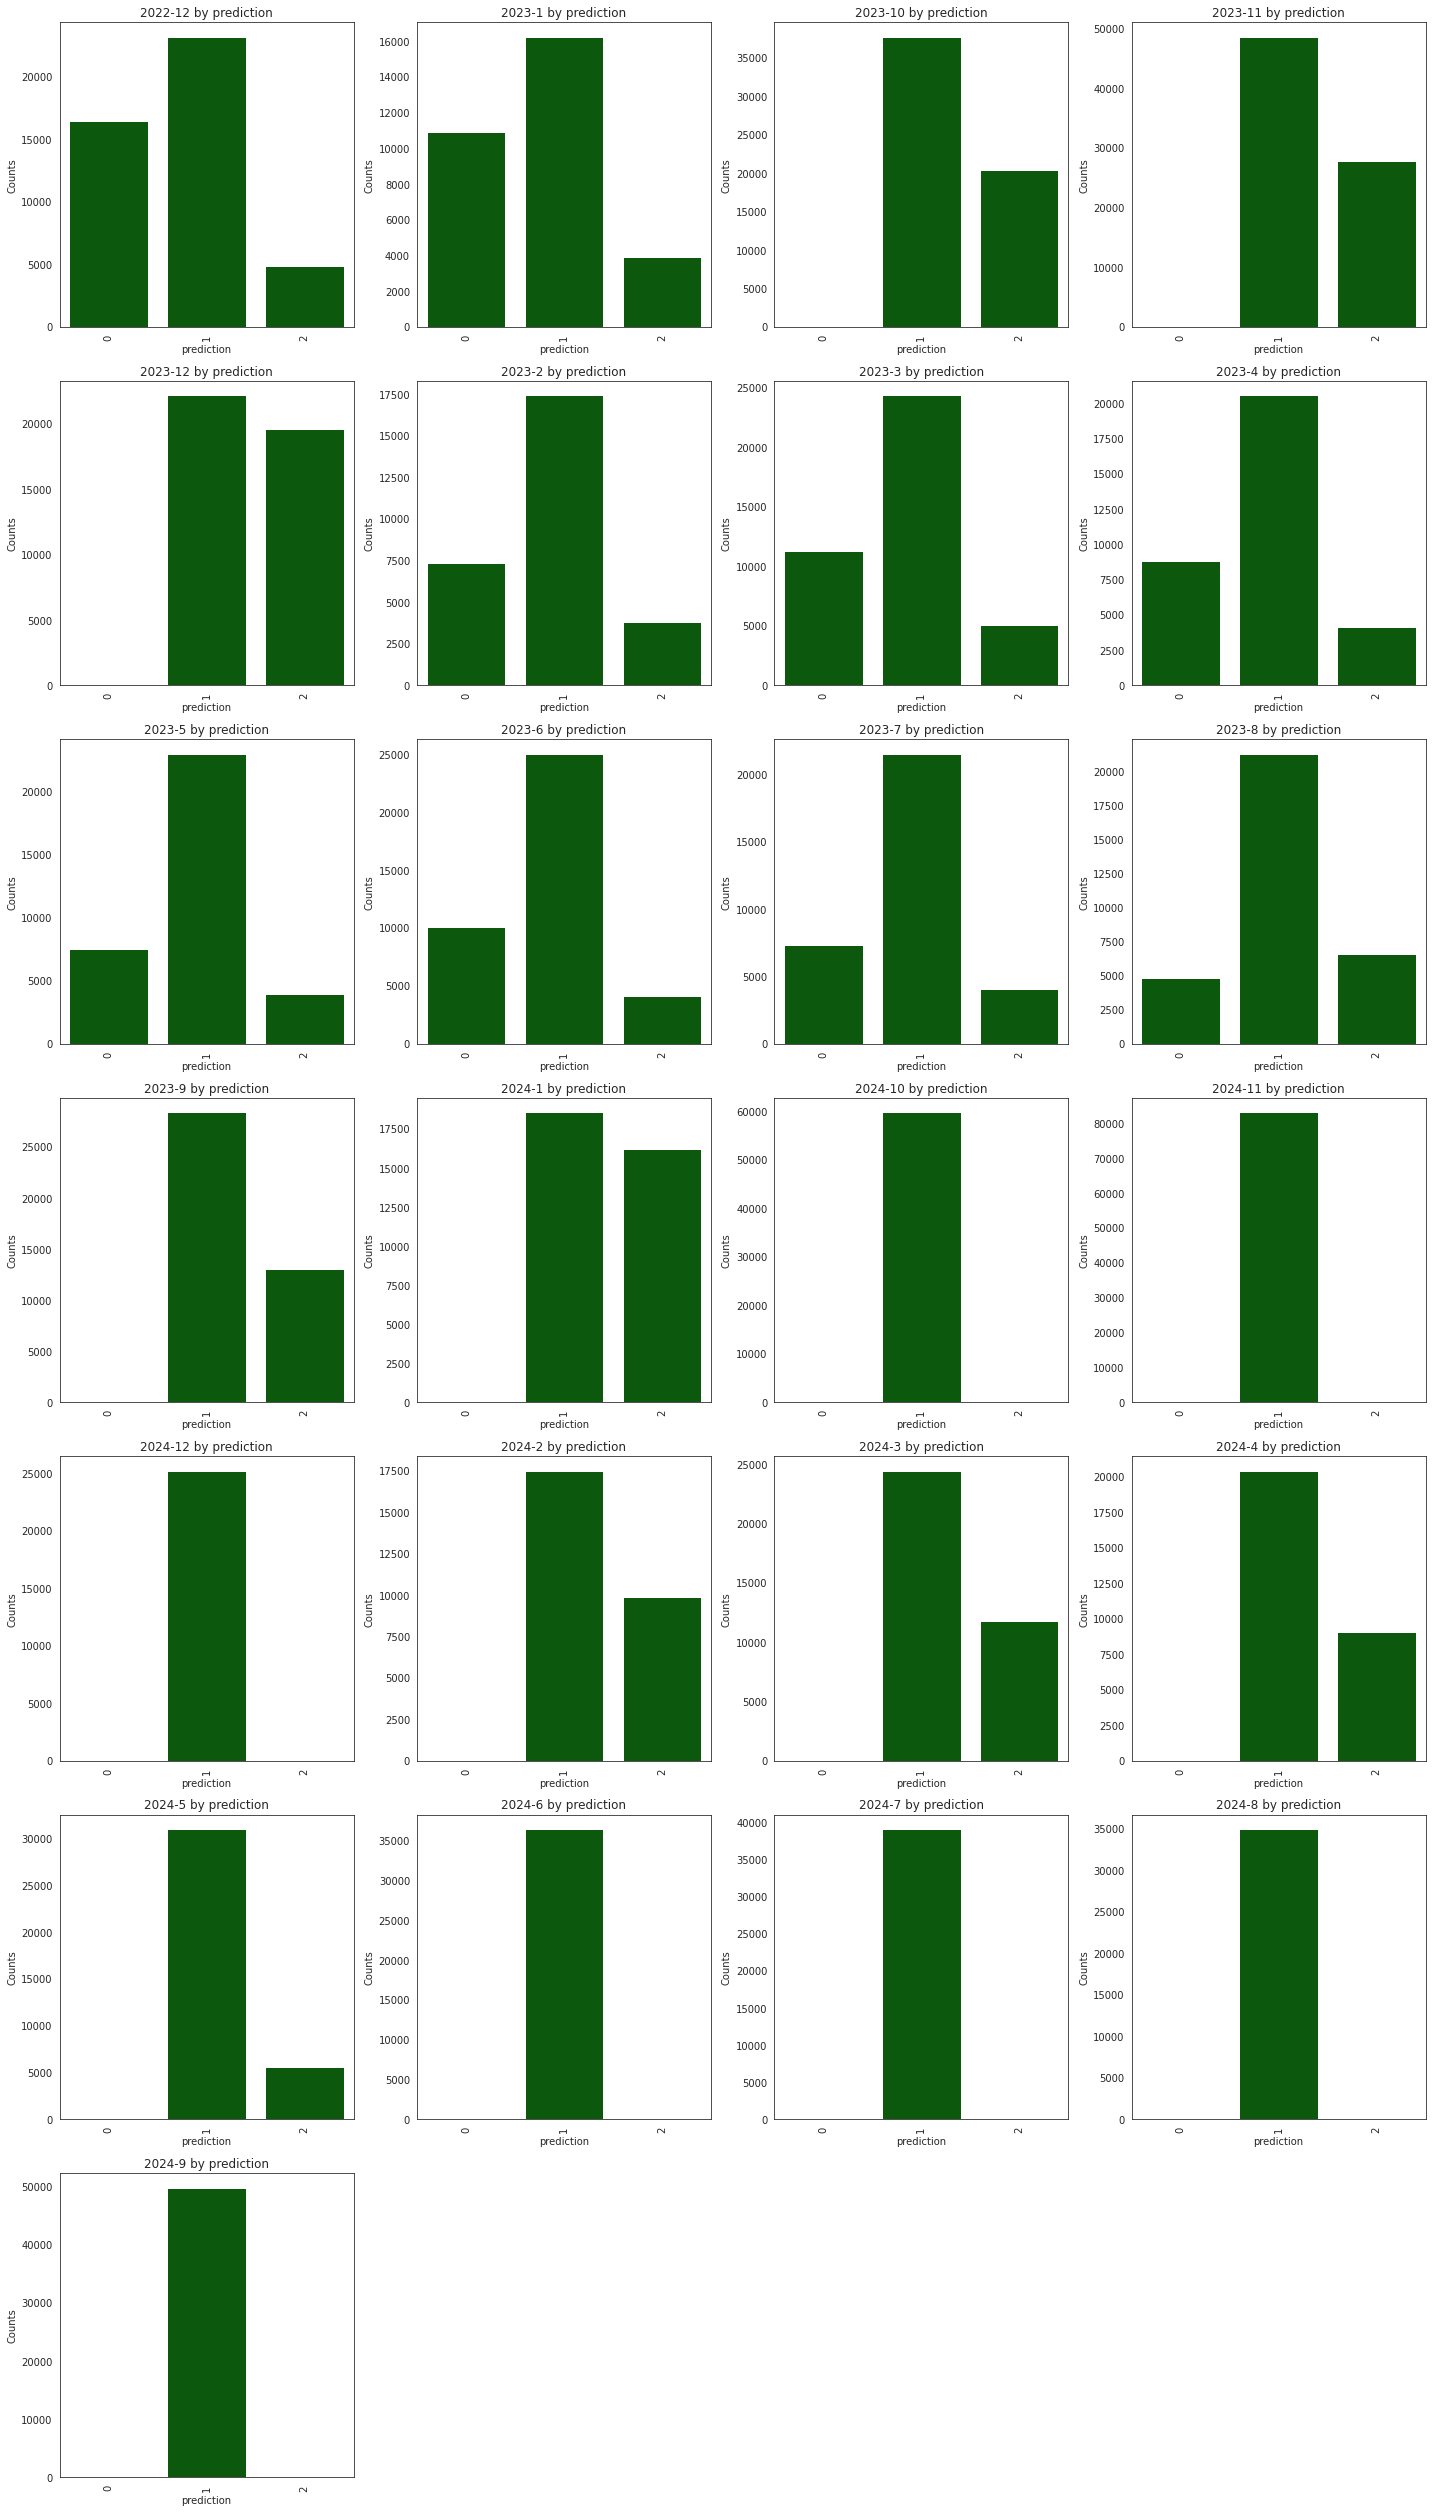

In [0]:
plot_profiling_barplots_spark(df_final, 'prediction', profiling_time)

In [0]:
profiling_metric = ['num_invoices','num_products','total_quantity','total_price','avg_unit_price','purchase_span_days','avg_quantity_per_invoice','recency_days']

In [0]:
# Group by 'prediction' and sum selected columns
agg_exprs = [F.sum(col).alias(col) for col in profiling_metric]

df_metric_cluster = df_final.groupBy('prediction').agg(*agg_exprs)

In [0]:
#display(df_metric_cluster)

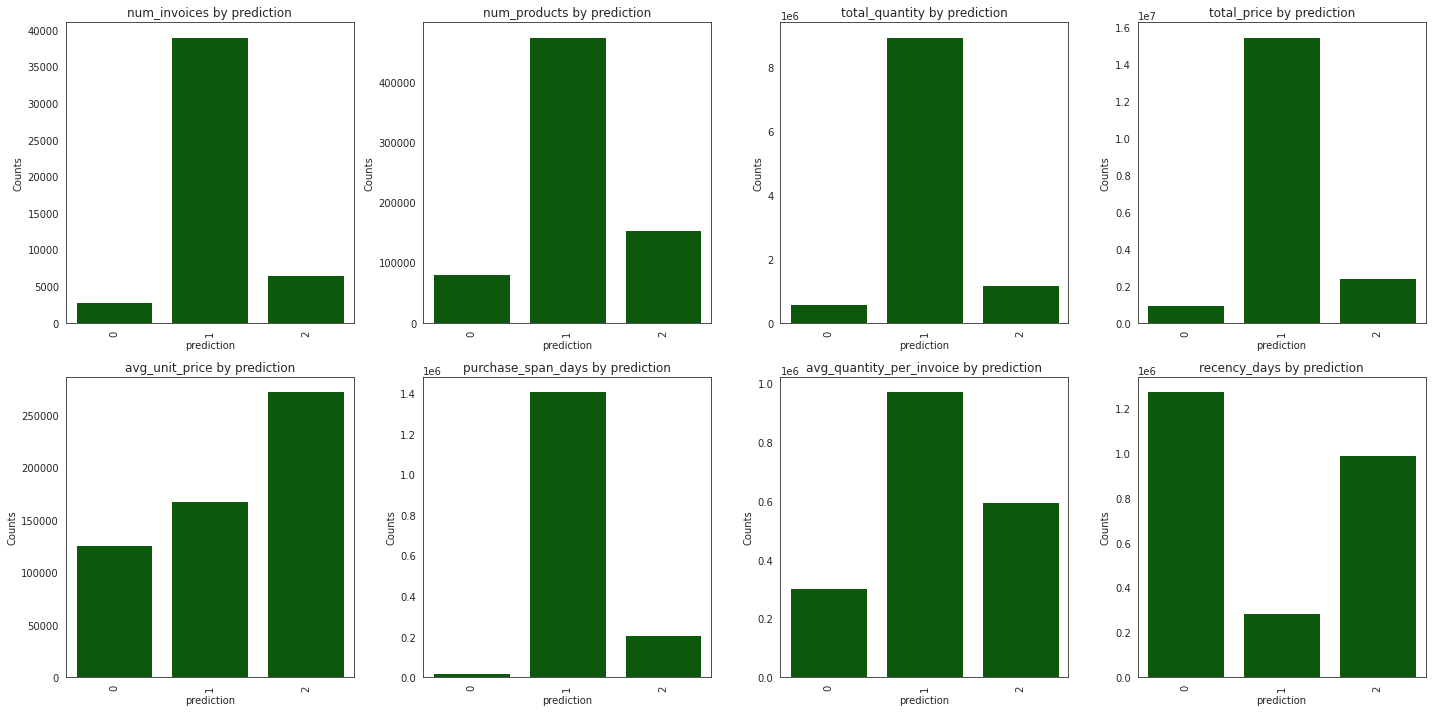

In [0]:
plot_profiling_barplots_spark(df_final, 'prediction', profiling_metric)